## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2020)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

Tutors: Nicholas James, Songhua Wu, Xuefeng Li, Yu Yao.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 0. Load Modules

In [49]:
# autoreload for modules
%load_ext autoreload
%autoreload 2

# Define your functions in organised individual python files. Don't throw them randomly in the notebook

## Import image processing modules
import os
import numpy as np
import pandas as pd # Used for simpler processing of data
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

## Import Algorithms
from algs import NmfHyperEstimator, NmfL2Estimator, ModifiedNMF

#Import preprocessing
from preprocessing import SaltNPepper, Gaussian, ImageNormalizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Dataset

### 1.0 Data Folder

In [9]:
# The structure of data folder.
!ls -l data

'ls' is not recognized as an internal or external command,
operable program or batch file.


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [10]:
# Load Extended YaleB dataset.
X_yaleb, Y_yaleb = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X_yaleb.shape, Y_yaleb.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [138]:
#Demonstrate noisy Image
reduce=6
V_hat, Y_hat = load_data(root='data/CroppedYaleB', reduce=reduce)
scaler = ImageNormalizer(min=None, max=None)

In [139]:
V_hat.shape

(896, 2414)

In [147]:
noise = SaltNPepper(p=0.1, r=0.4) 

V_snp = noise.fit_transform(V_hat)
V_snp = scaler.fit_transform(V_snp)

noise_g = Gaussian(mean=0, sigma=10) 
V_g = noise_g.fit_transform(V_hat)
V_g = scaler.fit_transform(V_g)

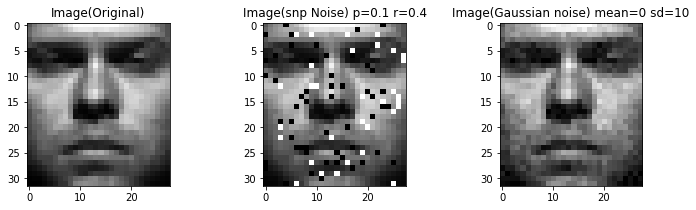

In [148]:
#Plot result.
#img_size = [i//3 for i in (126, 144)] #ORL
img_size = [i//reduce for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=0 sd=10')
plt.draw()
plt.savefig("noisyImage", dpi=100)
plt.show()

In [149]:
#Image Reconstruction
#Using Hypersurface
np.random.seed(0)
nmf_hyper = NmfHyperEstimator(n_components=50) # set n_components to num_classes.
#Salt n Pepper
H = nmf_hyper.fit_transform(V_snp)
W = nmf_hyper.components_
V_snp_reconstructed_hyper = W @ H
#Gaussian
H = nmf_hyper.fit_transform(V_g)
V_g_reconstructed_hyper = W @ H

In [150]:
#Using L2NMF
np.random.seed(0)
nmf_L2 = NmfL2Estimator(n_components=50) # set n_components to num_classes.
#SaltNPepper
H = nmf_L2.fit_transform(V_snp)
W = nmf_L2.components_
V_snp_reconstructed_L2 = W @ H
#Gaussian
H = nmf_L2.fit_transform(V_g)
V_g_reconstructed_L2 = W @ H

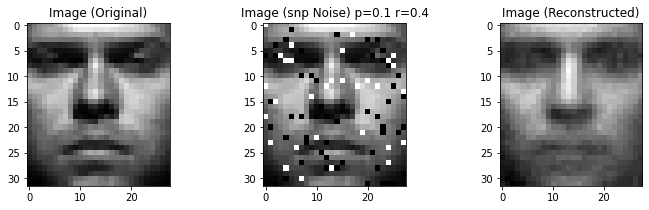

In [145]:
#Reconstruction (snp noise) using hyper
img_size = [i//reduce for i in (168, 192)]
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedHyper_snp", dpi=100)

ValueError: cannot reshape array of size 896 into shape (48,42)

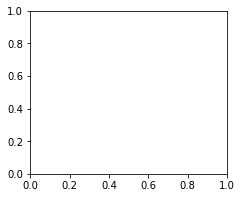

In [146]:
#Reconstruction (Gaussian noise) using hyper
img_size = [i//3 for i in (126, 144)] #CroppedYaleB
ind = 2 # index of demo image.
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Gaussian noise) mean=20, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_hyper[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedHyper_gaussian", dpi=100)

In [ ]:
#Reconstruction (snp noise) using L2NMF
img_size = [i//3 for i in (126, 144)] #CroppedYaleB
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_snp[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (snp Noise) p=0.1 r=0.4')
plt.subplot(133)
plt.imshow(V_snp_reconstructed_L2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedL2_snp", dpi=100)

In [ ]:
#Reconstruction (Gaussian noise) using L2NMF
img_size = [i//3 for i in (126, 144)] #CroppedYaleB
ind = 2 # index of demo image.
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Original)')
plt.subplot(132)
plt.imshow(V_g[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Gaussian noise) mean=20, sd=10')
plt.subplot(133)
plt.imshow(V_g_reconstructed_L2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image (Reconstructed)')
plt.savefig("reconstructedL2_gaussian", dpi=100)

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [11]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred


In [12]:
from sklearn.decomposition import NMF

# Transpose X for correct shape
class ModifiedNMF:
    def __init__(self, *args, **kwargs):
        self.nmf = NMF(*args, **kwargs)
    
    def fit(self, X, *args, **kwargs):
        X = X.T
        self.nmf.fit(X, *args, **kwargs)
        return self
    
    def transform(self, X, *args, **kwargs):
        X = X.T
        return self.nmf.transform(X, *args, **kwargs).T
    
    def fit_transform(self, X, *args, **kwargs):
        X = X.T
        return self.nmf.fit_transform(X, *args, **kwargs).T
    
    @property
    def components_(self):
        return self.nmf.components_.T

In [96]:
import textwrap
import itertools

def make_grid_alg_kwargs(alg, **kwargs):
    keys = []
    values_list = []
    for key, values in kwargs.items():
        keys.append(key)
        values_list.append(values)
        
    grid_kwargs = []
    for value_product in list(itertools.product(*values_list)):
        kwargs = {}
        grid_kwargs.append(kwargs)
        for key, value in zip(keys, value_product):
            kwargs[key] = value
    alg_kwargs_pairs = [(alg, kwargs) for kwargs in grid_kwargs]
    return alg_kwargs_pairs


def indent(text, amount, ch=' '):
        return textwrap.indent(text, amount * ch)


def rre_score(model, X, Y, Y_pred, W, H):
    return np.linalg.norm(X - W.dot(H)) / np.linalg.norm(X)


def acc_score(model, X, Y, Y_pred, W, H):
    return accuracy_score(Y, Y_pred)


def nmi_score(model, X, Y, Y_pred, W, H):
    return normalized_mutual_info_score(Y, Y_pred)

def benchmark(X, Y, scaler,
              alg_kwargs_pairs, all_n_components, # algs configs
              noise_kwargs_pairs, # noise configs
              metrics, metrics_names=None, # evaluations
              n_trials=5, pc_sample=0.9): # sampling configs
    """Benchmark algs and output long form evaluation results"""
    # Prepare column names in data frame
    if metrics_names is None:
        metrics_names = [m.__name__ for m in metrics]
    
    #evaluations = pd.DataFrame(columns = 
    #                           ["alg", "n_components", "kwargs", "noise_id", "noise_level", 
    #                            "ratio", "trial_id"] + metrics_names)
    evaluations = pd.DataFrame(columns = 
                               ["alg", "n_components", "kwargs", "noise_id", "trial_id"] + metrics_names)
    if isinstance(all_n_components, int):
        all_n_components = [all_n_components]
        
    # Prepare salt and pepper
    noises = []
    for i, (noise_alg, noise_kwargs) in enumerate(noise_kwargs_pairs):
        noise = noise_alg(**noise_kwargs)
        noises.append([noise, {"noise_id": i, **noise_kwargs}])
        
    # Prepare subseting
    subset_idxs = []
    for n in range(n_trials):
        subset_idxs.append(np.random.choice(range(X.shape[1]), size=int(0.9 * X.shape[1]), replace=False))
    # preprocess data
    X = scaler.fit_transform(X)
        
    for noise, noise_kwargs in noises:
        # Noise outer loop to keep it consistent between runs
        X_noise = noise.fit_transform(X)
        print(indent("Noise: " + str(noise_kwargs), 0))
        for i, subset_idx in enumerate(subset_idxs):
            print(indent("Trail: " + str(i), 4))
            X_subset = X_noise[:, subset_idx]
            Y_subset = Y[subset_idx]
            for alg in alg_kwargs_pairs:
                # Separate kwargs if additional kwargs are provided
                try:
                    if len(alg) == 2:
                        alg, alg_kwargs = alg
                except:
                    alg_kwargs = {}
                    
                print(indent("Alg: " + alg.__name__ + " " + str(alg_kwargs), 8))
                for k in all_n_components:
                    row = {**noise_kwargs}
                    row.update(
                        {"alg": alg.__name__, "n_components": k, "kwargs": alg_kwargs, "trial_id": i})
                    model = alg(n_components=k, **alg_kwargs)
                    H = model.fit_transform(X_subset)
                    W = model.components_
                    # print(model.__class__, "W", W.shape, "H", H.shape)
                    # Y_pred = assign_cluster_label(H.T, Y_subset)
                    Y_pred = assign_cluster_label(H.T, Y_subset)
                    
                    for metric, name in zip(metrics, metrics_names):
                        row[name] = metric(model, X_subset, Y_subset, Y_pred, W, H)
                    evaluations = evaluations.append(row, ignore_index=True)
    return evaluations

In [97]:
X, Y, scaler = X_orl, Y_orl, ImageNormalizer(min=None, max=None)
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator, 
    [NmfHyperEstimator, {"max_armijo": 0, "alpha0": 0.3, "beta0": 0.5}] # disable armijo search
]

metrics = [rre_score, acc_score, nmi_score]
metrics_names = ["rre", "acc_score", "nmi_score"]
n_trials = 3
pc_sample = 0.4

In [106]:
#Saltnpepper noise
all_n_components = range(30, 60, 20)
noise_alg = SaltNPepper
noise_levels = np.arange(0, 0.5, 0.1)
ratios = np.arange(0.0, 1.5, 0.5)
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, p=noise_levels, r=ratios)

evaluations = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'p': 0.0, 'r': 0.0}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}


KeyboardInterrupt: 

In [103]:
# Simple check for scores
(evaluations.query("alg == 'NmfHyperEstimator' and n_components == 30 and r==0.5")
 .sort_values(["rre"]))#, "acc_score"]))

,alg,n_components,kwargs,noise_id,trial_id,rre,acc_score,nmi_score,p,r
196,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",7,0,0.865884,0.163889,0.350151,0.4,0.5
205,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",7,1,0.866368,0.183333,0.340118,0.4,0.5
214,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",7,2,0.866460,0.186111,0.366053,0.4,0.5
142,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",5,0,0.880242,0.161111,0.324198,0.3,0.5
160,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",5,2,0.880483,0.175000,0.360604,0.3,0.5
151,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",5,1,0.880603,0.169444,0.354195,0.3,0.5
106,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",3,2,0.897003,0.163889,0.340147,0.2,0.5
88,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",3,0,0.897116,0.169444,0.353003,0.2,0.5
97,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",3,1,0.897206,0.161111,0.341522,0.2,0.5
34,NmfHyperEstimator,30,"{'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}",1,0,0.916198,0.186111,0.376329,0.1,0.5


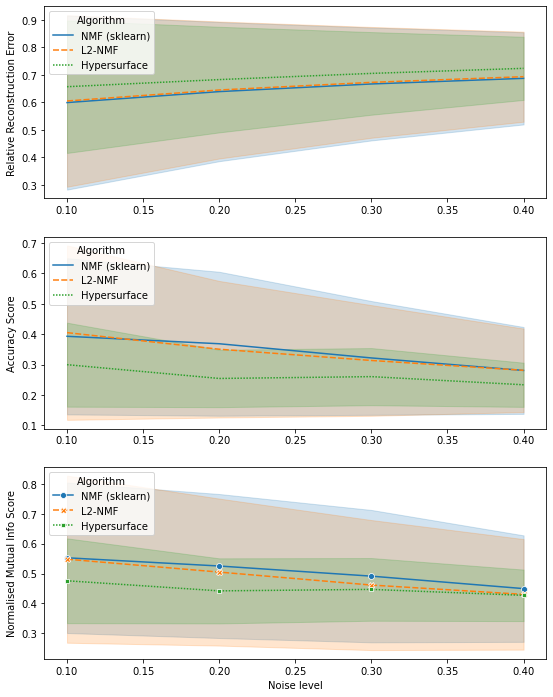

In [111]:
# Plotting RRE, Accuracy and NMI scores against different Salt & pepper noise levels for n_components=50
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="p",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="p",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="p",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Noise level")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.savefig("fig1")

UndefinedVariableError: name 'noise_level' is not defined

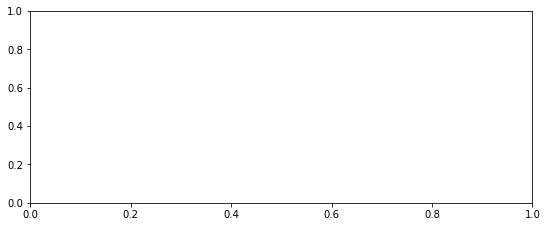

In [110]:
# Measuring RRE, Accuracy and NMI scores vs salt and pepper ratio for n_components=30 and noise at 0.1
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="ratio",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50 and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="ratio",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50 and noise_level==0.1"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="ratio",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50 and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band'
)
ax.set_xlabel("Ratio of salt and pepper (0 for all salt, 1 for all pepper)")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.savefig("fig2")

In [ ]:
# Gaussian noise
noise_alg = Gaussian
means = [25, 50]
sigmas = list(range(1, 30, 5))
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, mean=means, sigma=sigmas)
all_n_components = range(10, 60, 20)

X, Y, scaler = X_orl, Y_orl, ImageNormalizer()
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator, 
    [NmfHyperEstimator, {"max_armijo": 0, "alpha0": 0.3, "beta0": 0.5}] # disable armijo search
]

evaluations_g = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

In [43]:
(evaluations_g.query("alg == 'NmfHyperEstimator' and n_components == 100")# and ratio==0.5")
 .sort_values(["rre"]))#, "acc_score"]))

,alg,n_components,kwargs,noise_id,noise_level,ratio,trial_id,rre,acc_score,nmi_score,mean,sigma


In [47]:
type(evaluations_g)

pandas.core.frame.DataFrame

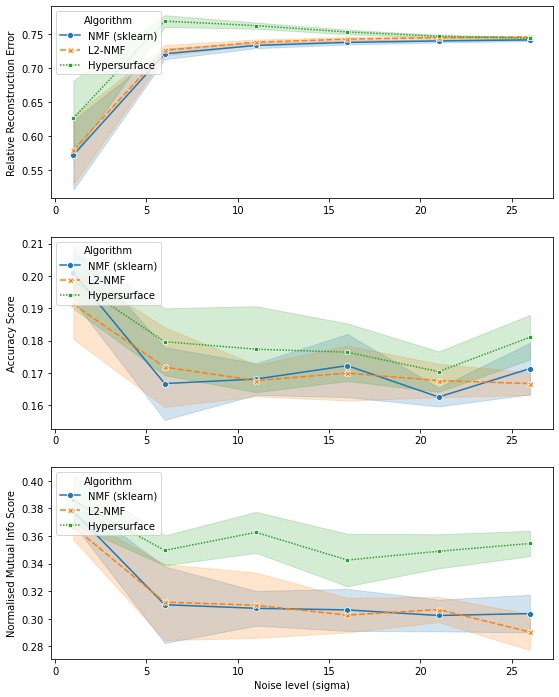

In [108]:
# Plotting RRE, Accuracy and NMI scores against different Gaussian noise levels for n_components=50
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="sigma",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g.query("n_components == 50"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    n_boot=1000,
    seed=None,
    markers=True,
    sort=True,
    err_style='band',
    legend=False,
)
ax.set_xlabel('')
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
ax.set_ylabel("Relative Reconstruction Error")

ax = fig.add_subplot(312)
sns.lineplot(
    x="sigma",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g.query("n_components == 50"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="sigma",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_g.query("n_components == 50"),# and noise_level==0.1"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Noise level (sigma)")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.savefig("Gaussian_ORL")

## CroppedYaleB

In [63]:

X, Y, scaler = X_yaleb, Y_yaleb, ImageNormalizer()
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator, 
    [NmfHyperEstimator, {"max_armijo": 0, "alpha0": 0.3, "beta0": 0.5}] # disable armijo search
]

metrics = [rre_score, acc_score, nmi_score]
metrics_names = ["rre", "acc_score", "nmi_score"]
n_trials = 3
pc_sample = 0.4

#Saltnpepper noise
all_n_components = range(10, 60, 20)
noise_alg = SaltNPepper
noise_levels = np.arange(0.1, 0.5, 0.1)
ratios = np.arange(0.0, 1, 0.5)
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, p=noise_levels, r=ratios)

evaluations_yale = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

# Gaussian noise
noise_alg = Gaussian
means = [25, 50]
sigmas = list(range(1, 30, 5))
noise_kwargs_pairs = make_grid_alg_kwargs(noise_alg, mean=means, sigma=sigmas)
all_n_components = range(10, 60, 20)

X, Y, scaler = X_orl, Y_orl, ImageNormalizer()
alg_kwargs_pairs = [
    ModifiedNMF, 
    NmfL2Estimator, 
    [NmfHyperEstimator, {"max_armijo": 0, "alpha0": 0.3, "beta0": 0.5}] # disable armijo search
]

evaluations_yale_g = benchmark(X_orl, Y_orl, scaler,
                        alg_kwargs_pairs, all_n_components,
                        noise_kwargs_pairs,
                        metrics, metrics_names,
                        n_trials, pc_sample
                       )

Noise: {'noise_id': 0, 'p': 0.1, 'r': 0.0}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 1, 'p': 0.1, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 2, 'p': 0.2, 'r': 0.0}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 3, 'p': 0.2, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 4, 'p': 0.30000000000000004, 'r': 0.0}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 5, 'p': 0.30000000000000004, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 6, 'p': 0.4, 'r': 0.0}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 7, 'p': 0.4, 'r': 0.5}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 0, 'mean': 25, 'sigma': 1}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 1, 'mean': 25, 'sigma': 6}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 2, 'mean': 25, 'sigma': 11}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 3, 'mean': 25, 'sigma': 16}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 4, 'mean': 25, 'sigma': 21}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 5, 'mean': 25, 'sigma': 26}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 6, 'mean': 50, 'sigma': 1}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 7, 'mean': 50, 'sigma': 6}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 8, 'mean': 50, 'sigma': 11}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 9, 'mean': 50, 'sigma': 16}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 10, 'mean': 50, 'sigma': 21}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
Noise: {'noise_id': 11, 'mean': 50, 'sigma': 26}
    Trail: 0
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 1
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}
    Trail: 2
        Alg: ModifiedNMF {}


G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
G:\Python\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


        Alg: NmfL2Estimator {}
        Alg: NmfHyperEstimator {'max_armijo': 0, 'alpha0': 0.3, 'beta0': 0.5}


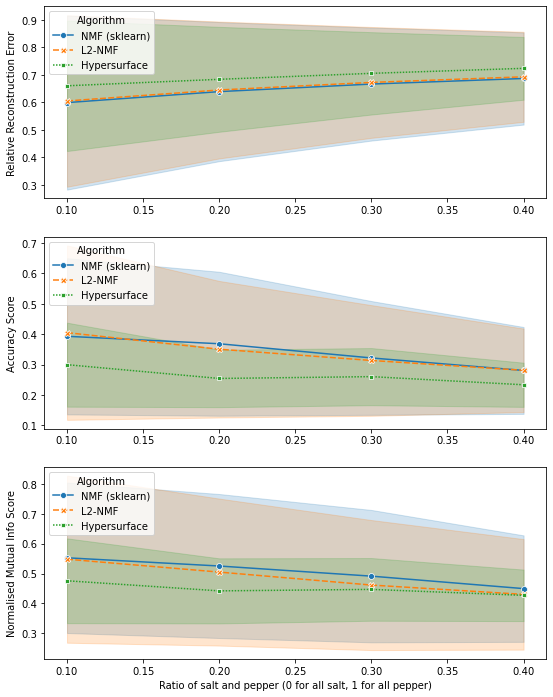

In [109]:
# Measuring RRE, Accuracy and NMI scores vs salt and pepper ratio for n_components=30 and noise at 0.1
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
sns.lineplot(
    x="p",
    y="rre",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations_yale.query("n_components == 50"),# and alg == 'NmfHyperEstimator'"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Relative Reconstruction Error")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(312)
sns.lineplot(
    x="p",
    y="acc_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel('')
ax.set_ylabel("Accuracy Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])

ax = fig.add_subplot(313)
sns.lineplot(
    x="p",
    y="nmi_score",
    hue="alg",
    #size="n_components",
    style="alg",
    data=evaluations.query("n_components == 50"),
    estimator='mean',
    #ci=95,
    ci = 'sd',
    markers=True,
    n_boot=1000,
    seed=None,
    sort=True,
    err_style='band',
    legend='full',
)
ax.set_xlabel("Ratio of salt and pepper (0 for all salt, 1 for all pepper)")
ax.set_ylabel("Normalised Mutual Info Score")
ax.legend(title="Algorithm", loc="upper left", labels=['NMF (sklearn)','L2-NMF','Hypersurface'])
plt.savefig("snp_croppedYaleB")

In [ ]:
DataFrame.to_latex